## Introduction:
This notebook preforms Data Integration and Reshaping for the two different data sources, indicated by S1 and S2 respectively, and generated one unified table.
The two datasets are
* S1 (data_s1_ass3.csv): contains 4,600 records 
* S2 (data_s2_ass3.xml): contains 430 records

There are 2 tasks includes:
1. Integration between S1 and S2
2. Data Normalization (z-score normalization, Min-Max normalization and log transformation)
-----------------------------

### Import libraries:

In [40]:
import numpy as np
import pandas as pd
import math
import datetime as dt                # for data/time format
import xml.etree.ElementTree as ET  # for parsing xml using Element Tree

from sklearn import preprocessing   # for data normalization

import seaborn as sns               # for data visualization
import matplotlib.pyplot as plt

## Task 1. Integration between S1 and S2:
Task contains: 
1. Parsing raw data for S1 and S2.
2. xmldf['address']: 
    * Extract data from 'address' and separate to 'street', 'city', 'statezip', 'country data'.
3. xmldf['street'] : 
    * Full name to abbreviation (e.g. Avenue to Ave, North to N).
4. xmldf['statezip', 'country']: 
    * Full name to abbreviation for 'Washington' to 'WA' and 'United States of America' to 'USA'.
5. xmldf['basementArea','livingArea','lotArea','upperArea']: 
    * Change number measured in square meters to square feet. 
    * None replaced by zero. 
    * Update columns name to the same as name in csv file dataset.
6. xmldf['renovateYear', 'buildYear']:
    * '0' to NaN for 'renovateYear' (to be same as csv dataset to represent data for houses never been renovated).
    * Update columns name to the same as name in csv file dataset.
7. xmldf['view', 'waterfront']: 
    * None replaced by zero for 'waterfront'. 
    * Convert to integer data type.
8. xmldf['soldDate', 'date']: 
    * Change date/time format to ISO 8601 same as format in csv file dataset.
9. csvdf['price']: 
    * Convert price number shown in full digital number.                    
    (raw data shown in number with word 'k' or 'm'prices which represent \$1,000 and \$1,000,000, respectively)
10. csvdf['date'] : 
    * Data in column 'date' are date of house sold, so change the column's name to 'soldDate' to be same as the coloumn name in xml file dataset. 
    (In xml file dataset, column 'date' represent record date while column 'soldDate' represent the date of house sold)
11. Standardize data type for columns that both datasets have.
12. Merge two datasets:
    * Duplication record will be removed when two dataset merged.

### 1. Parsing raw data for S1 and S2:

Parsing raw data for S1 (xml file)-

In [2]:
csvdf_raw = pd.read_csv("./data_s1_ass3.csv")
csvdf_raw.sort_index(axis=1, inplace=True)   #sort by columns name
csvdf_raw.head(1)

,bathrooms,bedrooms,city,condition,country,date,floors,price,sqft_above,sqft_basement,sqft_living,sqft_lot,statezip,street,view,waterfront,yr_built,yr_renovated
0,1.5,3,Shoreline,3,USA,20140502T000000,1.5,313k,1340,0,1340,7912,WA 98133,18810 Densmore Ave N,0,0,1955,NaN


Parsing raw data for S2 (csv file)-

In [3]:
xml_data = open("./data_s2_ass3.xml").read() 
def xmldf(xml_data): #define a function to make all record data into a dataframe
    root = ET.XML(xml_data) # element tree
    all_records = [] 
    for i, child in enumerate(root): #looping through root tree
        record = {} 
        for subchild in child: #iterate through the subchildren
            record[subchild.tag] = subchild.text #extract data under tags
        all_records.append(record) #append records 
    return pd.DataFrame(all_records) #return records as DataFrame

xmldf_raw = xmldf(xml_data)
xmldf_raw.sort_index(axis=1, inplace=True) #sort by columns name
xmldf_raw.head(1)

,address,basementArea,bathrooms,bedrooms,buildYear,date,floors,livingArea,lotArea,price,renovateYear,soldDate,upperArea,view,waterfront
0,"10515, 115th Place Northeast, Juanita, Kirklan...",None,1.75,3,1986,2014-07-19,1.0,158.8641984,814.48095168,630000,0,2014-07-09,158.8641984,None,None


### 2. xmldf['address']: 
Extract data from 'address' and separate to 'street', 'city', 'statezip', 'country data'.

In [4]:
#use copy dataframe for the integration and remain the raw data frame unchanged
xmldf = xmldf_raw.copy()

#Extract data to new columns:
street = []
city = [] 
statezip = []
country = []
for item in xmldf["address"]:
    data = item.split(", ")
    if len(data) > 6:
        str_temp = data[0]+" "+ data[1]
        street.append(str_temp)
        city.append(data[-5]) 
        sta_temp = data[-3]+" "+ data[-2]
        statezip.append(sta_temp) 
        country.append(data[-1]) 
    else:
        street.append(data[0])
        city.append(data[-5]) 
        sta_temp = data[-3]+" "+ data[-2]
        statezip.append(sta_temp) 
        country.append(data[-1]) 
        
temp_df = pd.DataFrame({"street": street, "city" : city, "statezip": statezip,"country": country})
xmldf = pd.concat([xmldf, temp_df], axis=1)

#delete the address column
cols = ['address']
xmldf.drop(cols,axis=1, inplace=True )
xmldf.head(1)

,basementArea,bathrooms,bedrooms,buildYear,date,floors,livingArea,lotArea,price,renovateYear,soldDate,upperArea,view,waterfront,city,country,statezip,street
0,None,1.75,3,1986,2014-07-19,1.0,158.8641984,814.48095168,630000,0,2014-07-09,158.8641984,None,None,Kirkland,United States of America,Washington 98033,10515 115th Place Northeast


#### Note: 
When extract data from address, we roughly check the structure of the address columns first by using xml editor, 
and we find that data separated by ", ". 
* If there are more than 6 data separated by ", " for the record:
    * 'street' data will be the combination of the first and second data in the record. 
    * 'city' will be the 5th data from the end. 
    * 'state' +  'zipcode' will be the 3rd and 2rd data from the end.
    * 'country' will be the last data.
* If there are less or equal 6 data separated by ", " for the record:
    * 'street' data will be the first data in the record. 
    * 'city', 'state' and 'country' are in the same sequence of record having more than 6 data separated by ", " .
    
We base on the finding to extract the data from 'address' column to get the data for 'street', 'city', 'statezip' and 'country'.

In [5]:
#print the result of extracting the data from 'address'
print xmldf.statezip.unique()
print ''
print xmldf.country.unique()
print ''
print xmldf.city.unique()

['Washington 98033' 'Washington 98117' 'Washington 98103'
 'Washington 98125' 'Washington 98144' 'Washington 98122'
 'Washington 98108' 'Washington 98133' 'Washington 98116'
 'Washington 98115' 'Washington 98126' 'Washington 98105'
 'Washington 98178' 'Washington 98199' 'Washington 98034'
 'Washington 98042' 'Washington 98102' 'Washington 98040'
 'Washington 98053' 'Washington 98112' 'Washington 98146'
 'Washington 98014' 'Washington 98038' 'Washington 98006'
 'Washington 98056' 'Washington 98027' 'Washington 98029'
 'Washington 98155' 'Washington 98058' 'Washington 98023'
 'Washington 98118' 'Washington 98168' 'Washington 98032'
 'Washington 98109' 'Washington 98177' 'Washington 98030'
 'Washington 98119' 'Washington 98074' 'Washington 98004'
 'Washington 98027; 98006' 'Washington 98031' 'Washington 98065'
 'Washington 98002' 'Washington 98047' 'Washington 98059'
 'King County Washington' 'Washington 98166' 'Washington 98107'
 'Washington 98001' 'Washington 98055' 'Washington 98008'
 

#### Note:
There are some error in 'statezip' that doesn't contains 'state' + 'zipcode' but 'county' + 'state' , and in 'city' that contains address data instead of city data.

In [6]:
#select the error data to see what happened to the record.
print xmldf_raw.address[xmldf_raw.address.str.contains('290th Avenue Southeast')]
address = xmldf_raw.address[xmldf_raw.address.str.contains('290th Avenue Southeast')]
for item in address:
    print item

89    290th Avenue Southeast, Hobart, King County, W...
Name: address, dtype: object
290th Avenue Southeast, Hobart, King County, Washington, United States of America


#### Note:
Record no.89 without zip code make our python code extract the wrong data as the sequence of the data in the record is different from other records. 

In [7]:
#find record that the house located in the same city Hobart
print xmldf_raw.address[xmldf_raw.address.str.contains('Hobart')]
address = xmldf_raw.address[xmldf_raw.address.str.contains('Hobart')]
for item in address:
    print item

37    24311, Southeast 252nd Avenue, Hobart, King Co...
89    290th Avenue Southeast, Hobart, King County, W...
Name: address, dtype: object
24311, Southeast 252nd Avenue, Hobart, King County, Washington, 98038, United States of America
290th Avenue Southeast, Hobart, King County, Washington, United States of America


#### Note:
Zip code for Hobart is 98038.

Make correction of data for record no.89 for 'street' and 'statezip' with zip code is 98038.

In [9]:
xmldf.loc[89, "city"] = 'Hobart'
xmldf.loc[89,  "statezip"] = 'Washington 98038'
print xmldf.loc[89, "city"] 
print xmldf.loc[89,  "statezip"] 

Hobart
Washington 98038


### 3. xmldf['street'] : 
Full name to abbreviation (e.g. Avenue to Ave, North to N).

In [10]:
street_abbrev = {r'(Northeast)':'NE', r'(Southeast)':'SE', r'(Southwest)':'SW', r'(Northwest)' : 'NW',
                 r'(North)':'N', r'(East)':'E', r'(South)':'S', r'(West)':'W', 
                 r'(Avenue)':'Ave', r'(Court)':'Ct', r'(Circle)':'Cir', r'(Drive)':'Dr', r'(Mount)':'Mt',
                 r'(Place)':'Pl', r'(Plaza)':'Plz', r'(Road)':'Rd', r'(Street)':'St', r'(Lane)':'Ln'}
    
for name, abbrev in street_abbrev.items():
    xmldf['street']= xmldf['street'].str.replace(name, abbrev) 
xmldf.head(1)

,basementArea,bathrooms,bedrooms,buildYear,date,floors,livingArea,lotArea,price,renovateYear,soldDate,upperArea,view,waterfront,city,country,statezip,street
0,None,1.75,3,1986,2014-07-19,1.0,158.8641984,814.48095168,630000,0,2014-07-09,158.8641984,None,None,Kirkland,United States of America,Washington 98033,10515 115th Pl NE


### 4. xmldf['statezip', 'country']: 
Full name to abbreviation for 'Washington' to 'WA' and 'United States of America' to 'USA'.

In [11]:
statezip_abbrev = {'Washington' : 'WA'}
for name, abbrev in statezip_abbrev.items():
    xmldf['statezip']= xmldf['statezip'].str.replace(name, abbrev)

country_abbrev = {'United States of America' : 'USA'}
for name, abbrev in country_abbrev.items():
    xmldf['country']= xmldf['country'].str.replace(name, abbrev) 
xmldf.head(1)

,basementArea,bathrooms,bedrooms,buildYear,date,floors,livingArea,lotArea,price,renovateYear,soldDate,upperArea,view,waterfront,city,country,statezip,street
0,None,1.75,3,1986,2014-07-19,1.0,158.8641984,814.48095168,630000,0,2014-07-09,158.8641984,None,None,Kirkland,USA,WA 98033,10515 115th Pl NE


### 5. xmldf['basementArea','livingArea','lotArea','upperArea']: 
* Change number measured in square meters to square feet. 
* None replaced by zero. 
* Update columns name to the same as name in csv file dataset.

In [12]:
#convert object to numeric data type
xmldf[['basementArea','livingArea','lotArea','upperArea']]= xmldf[[
    'basementArea','livingArea','lotArea','upperArea']].apply(lambda x: pd.to_numeric(x, errors='coerce'))
xmldf.info()
#basementArea has None value

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 430 entries, 0 to 429
Data columns (total 18 columns):
basementArea    181 non-null float64
bathrooms       430 non-null object
bedrooms        430 non-null object
buildYear       430 non-null object
date            430 non-null object
floors          430 non-null object
livingArea      430 non-null float64
lotArea         430 non-null float64
price           430 non-null object
renovateYear    430 non-null object
soldDate        430 non-null object
upperArea       430 non-null float64
view            34 non-null object
waterfront      3 non-null object
city            430 non-null object
country         430 non-null object
statezip        430 non-null object
street          430 non-null object
dtypes: float64(4), object(14)
memory usage: 60.5+ KB


In [13]:
#'livingArea','lotArea','upperArea' -> unit= sqm
# sqft : sqm  = 1: 0.092903
# sqm to sqft
xmldf[['basementArea','livingArea','lotArea','upperArea']]= xmldf[['basementArea','livingArea',
                                                    'lotArea',
                                                    'upperArea']].apply(lambda x: pd.Series.round(x/0.092903, 0))
#basementArea None to 0 
xmldf['basementArea'].fillna(0, inplace=True)

#normalize name for 'livingArea','lotArea','upperArea'
xmldf.rename(columns={'basementArea': 'sqft_basement', 
                      'livingArea': 'sqft_living',
                      'lotArea': 'sqft_lot', 
                      'upperArea': 'sqft_above'}, inplace=True)
xmldf.head(1)

,sqft_basement,bathrooms,bedrooms,buildYear,date,floors,sqft_living,sqft_lot,price,renovateYear,soldDate,sqft_above,view,waterfront,city,country,statezip,street
0,0.0,1.75,3,1986,2014-07-19,1.0,1710.0,8767.0,630000,0,2014-07-09,1710.0,None,None,Kirkland,USA,WA 98033,10515 115th Pl NE


### 6. xmldf['renovateYear', 'buildYear']:
* '0' to NaN for 'renovateYear' (to be same as csv dataset to represent data for houses never been renovated).
* Update columns name to the same as name in csv file dataset.

In [14]:
# renovateYear '0' to NaN
xmldf['renovateYear']= xmldf['renovateYear'].replace('0', np.nan) 

# normalize name for renovateYear and buildYear
xmldf.rename(columns={'renovateYear': 'yr_renovated', 
                      'buildYear': 'yr_built'}, inplace=True)                    
xmldf.head(1)       

,sqft_basement,bathrooms,bedrooms,yr_built,date,floors,sqft_living,sqft_lot,price,yr_renovated,soldDate,sqft_above,view,waterfront,city,country,statezip,street
0,0.0,1.75,3,1986,2014-07-19,1.0,1710.0,8767.0,630000,NaN,2014-07-09,1710.0,None,None,Kirkland,USA,WA 98033,10515 115th Pl NE


### 7. xmldf['view', 'waterfront']: 
* None replaced by zero for 'waterfront'. 
* Convert to integer data type.

In [15]:
xmldf['waterfront']= pd.to_numeric(xmldf['waterfront'], errors='coerce')
#xmldf['waterfront'].unique()   :  array([  0.,  nan])
xmldf['waterfront'].fillna(0, inplace=True)
xmldf['waterfront'] = xmldf['waterfront'].astype(int)

xmldf['view']= pd.to_numeric(xmldf['view'], errors='coerce')
xmldf['view'].fillna(0, inplace=True)
xmldf['view'] = xmldf['view'].astype(int)
xmldf.head(1)

,sqft_basement,bathrooms,bedrooms,yr_built,date,floors,sqft_living,sqft_lot,price,yr_renovated,soldDate,sqft_above,view,waterfront,city,country,statezip,street
0,0.0,1.75,3,1986,2014-07-19,1.0,1710.0,8767.0,630000,NaN,2014-07-09,1710.0,0,0,Kirkland,USA,WA 98033,10515 115th Pl NE


### 8. xmldf['soldDate', 'date']: 
* Change date/time format to ISO 8601 same as format in csv file dataset.

In [16]:
#datatime to format ISO 8601
xmldf['soldDate'] = pd.to_datetime(xmldf['soldDate'])
xmldf['soldDate']= xmldf['soldDate'].apply(lambda x: dt.datetime.strftime(x, '%Y%m%dT%H%M%S'))

xmldf['date'] = pd.to_datetime(xmldf['date'])
xmldf['date']= xmldf['date'].apply(lambda x: dt.datetime.strftime(x, '%Y%m%dT%H%M%S'))
#note: 'date' in xmldf represent record date.

xmldf.sort_index(axis=1, inplace=True) #sort by columns name
xmldf.head(1)

,bathrooms,bedrooms,city,country,date,floors,price,soldDate,sqft_above,sqft_basement,sqft_living,sqft_lot,statezip,street,view,waterfront,yr_built,yr_renovated
0,1.75,3,Kirkland,USA,20140719T000000,1.0,630000,20140709T000000,1710.0,0.0,1710.0,8767.0,WA 98033,10515 115th Pl NE,0,0,1986,NaN


### 9. csvdf['price']: 
* Convert price number shown in full digital number.                    
    (raw data shown in number with word 'k' or 'm' represent \$1,000 and \$1,000,000, respectively)

In [17]:
#use copy dataframe for the integration and remain the raw data frame unchanged
csvdf = csvdf_raw.copy()

#To change price data to all digital number:
#first, get notation k and m which represent 1000$ and 1000000$ respectively.
csvdf['price_scale'] = csvdf['price'].str.extract(r'([km])',expand=True)
scale_num = {'k':1000, 'm':1000000}
for scale, num in scale_num.items():
    csvdf['price_scale'] = csvdf['price_scale'].replace(scale, num) 
    
#second, get number without notation k and m
csvdf['price_num'] = csvdf['price'].str.extract(r'(\d+\.?\d*)',expand=True)
csvdf['price_num'] = pd.to_numeric(csvdf['price_num'], errors='coerce')
#errors='coerce' for convert problematic values to NaN:

#revise price data to all digital number that = number * scale 
#for example: 50k = 50 * 1000 = 50000
csvdf['price'] = csvdf['price_num']* csvdf['price_scale'] 
csvdf['price'] = csvdf['price'].astype(object)   # float64 to obj

#drop unecessary columns
cols = ['price_scale', 'price_num']
csvdf.drop(cols,axis=1, inplace=True )
csvdf.head(1)

,bathrooms,bedrooms,city,condition,country,date,floors,price,sqft_above,sqft_basement,sqft_living,sqft_lot,statezip,street,view,waterfront,yr_built,yr_renovated
0,1.5,3,Shoreline,3,USA,20140502T000000,1.5,313000,1340,0,1340,7912,WA 98133,18810 Densmore Ave N,0,0,1955,NaN


### 10. csvdf['date'] : 
* Data in column 'date' are date of house sold, so change column's name to 'soldDate' to be same as the coloumn's name in xml file dataset.    
    (In xml file dataset, column 'date' represent record date while column 'soldDate' represent the date of house sold)

In [18]:
csvdf.rename(columns={'date': 'soldDate'}, inplace=True)
csvdf.sort_index(axis=1, inplace=True)
csvdf.head(1)

,bathrooms,bedrooms,city,condition,country,floors,price,soldDate,sqft_above,sqft_basement,sqft_living,sqft_lot,statezip,street,view,waterfront,yr_built,yr_renovated
0,1.5,3,Shoreline,3,USA,1.5,313000,20140502T000000,1340,0,1340,7912,WA 98133,18810 Densmore Ave N,0,0,1955,NaN


### 11. Standardize data type for coloumns that both datasets have.

In [19]:
#check data types for both datasets
print xmldf.dtypes
print csvdf.dtypes

bathrooms         object
bedrooms          object
city              object
country           object
date              object
floors            object
price             object
soldDate          object
sqft_above       float64
sqft_basement    float64
sqft_living      float64
sqft_lot         float64
statezip          object
street            object
view               int64
waterfront         int64
yr_built          object
yr_renovated      object
dtype: object
bathrooms        float64
bedrooms           int64
city              object
condition          int64
country           object
floors           float64
price             object
soldDate          object
sqft_above         int64
sqft_basement      int64
sqft_living        int64
sqft_lot           int64
statezip          object
street            object
view               int64
waterfront         int64
yr_built           int64
yr_renovated     float64
dtype: object


In [20]:
#convert data type for columns 
xmldf['bathrooms'] = xmldf['bathrooms'].astype(float)
xmldf['bedrooms'] = xmldf['bedrooms'].astype(int)
xmldf['floors'] = xmldf['floors'].astype(float)
xmldf['price'] = xmldf['price'].astype(float)
xmldf['yr_built'] = xmldf['yr_built'].astype(int)
xmldf['yr_renovated'] = xmldf['yr_renovated'].astype(float)

csvdf['price'] = csvdf['price'].astype(float)

### 12. Merge two datasets:
* Duplication records will be removed when two datasets merged.

In [47]:
df = pd.merge(xmldf,csvdf, how='outer')
df.head(5)

,bathrooms,bedrooms,city,country,date,floors,price,soldDate,sqft_above,sqft_basement,sqft_living,sqft_lot,statezip,street,view,waterfront,yr_built,yr_renovated,condition
0,1.75,3.0,Kirkland,USA,20140719T000000,1.0,630000.0,20140709T000000,1710.0,0.0,1710.0,8767.0,WA 98033,10515 115th Pl NE,0.0,0.0,1986.0,NaN,4.0
1,3.25,3.0,Seattle,USA,20140710T000000,3.0,599950.0,20140709T000000,1830.0,0.0,1830.0,1804.0,WA 98117,1501 NW 90th St,0.0,0.0,2014.0,NaN,3.0
2,2.00,3.0,Seattle,USA,20140716T000000,1.0,680000.0,20140709T000000,980.0,800.0,1780.0,5720.0,WA 98103,537 N 70th St,0.0,0.0,1925.0,NaN,5.0
3,1.00,3.0,Seattle,USA,20140713T000000,2.0,335500.0,20140709T000000,1370.0,0.0,1370.0,6780.0,WA 98125,12008 35th Ave NE,0.0,0.0,1930.0,NaN,3.0
4,2.50,3.0,Kirkland,USA,20140718T000000,2.0,379000.0,20140709T000000,1530.0,0.0,1530.0,2913.0,WA 98033,11807 NE 105th Ct,0.0,0.0,1986.0,NaN,4.0


In [48]:
#check data after merged
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5000 entries, 0 to 4999
Data columns (total 19 columns):
bathrooms        5000 non-null float64
bedrooms         5000 non-null float64
city             5000 non-null object
country          5000 non-null object
date             430 non-null object
floors           5000 non-null float64
price            5000 non-null float64
soldDate         5000 non-null object
sqft_above       5000 non-null float64
sqft_basement    5000 non-null float64
sqft_living      5000 non-null float64
sqft_lot         5000 non-null float64
statezip         5000 non-null object
street           5000 non-null object
view             5000 non-null float64
waterfront       5000 non-null float64
yr_built         5000 non-null float64
yr_renovated     249 non-null float64
condition        4600 non-null float64
dtypes: float64(13), object(6)
memory usage: 781.2+ KB


In [49]:
#convert data type after merged
df['bedrooms'] = df['bedrooms'].astype(int)
df['price'] = df['price'].astype(int)
df['sqft_above'] = df['sqft_above'].astype(int)
df['sqft_basement'] = df['sqft_basement'].astype(int)
df['sqft_living'] = df['sqft_living'].astype(int)
df['sqft_lot'] = df['sqft_lot'].astype(int)
df['view'] = df['view'].astype(int)
df['waterfront'] = df['waterfront'].astype(int)
df['yr_built'] = df['yr_built'].astype(int)

#drop unecessary columns
cols = ['date'] # removed data record date
df.drop(cols,axis=1, inplace=True )
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5000 entries, 0 to 4999
Data columns (total 18 columns):
bathrooms        5000 non-null float64
bedrooms         5000 non-null int64
city             5000 non-null object
country          5000 non-null object
floors           5000 non-null float64
price            5000 non-null int64
soldDate         5000 non-null object
sqft_above       5000 non-null int64
sqft_basement    5000 non-null int64
sqft_living      5000 non-null int64
sqft_lot         5000 non-null int64
statezip         5000 non-null object
street           5000 non-null object
view             5000 non-null int64
waterfront       5000 non-null int64
yr_built         5000 non-null int64
yr_renovated     249 non-null float64
condition        4600 non-null float64
dtypes: float64(4), int64(9), object(5)
memory usage: 742.2+ KB


#### Note:  
* Data type of 'condition' column cannot be converted to integer as it contains NaN value. NaN value represent missing data.
* Remove 'date' from the merged dataset as the data are the record date in xml file.
* NaN value existed in 'yr_renovated' and 'condition'.
* After merged, duplication records have been removed and the merged dataset contains 5,000 records in total.

#### Task 1 done. 
------------------

## Task 2. Data Normalization 
## (z-score normalization, Min-Max normalization and log transformation):
Task contains: 
1. Apply z-score normalization to 'price'.
2. Apply Min-Max normalization to 'price'.
3. Apply log transformation to 'price'.
4. Output integrated dataset.

#### Plot  price data, and observe the range and the centre of the distribution.

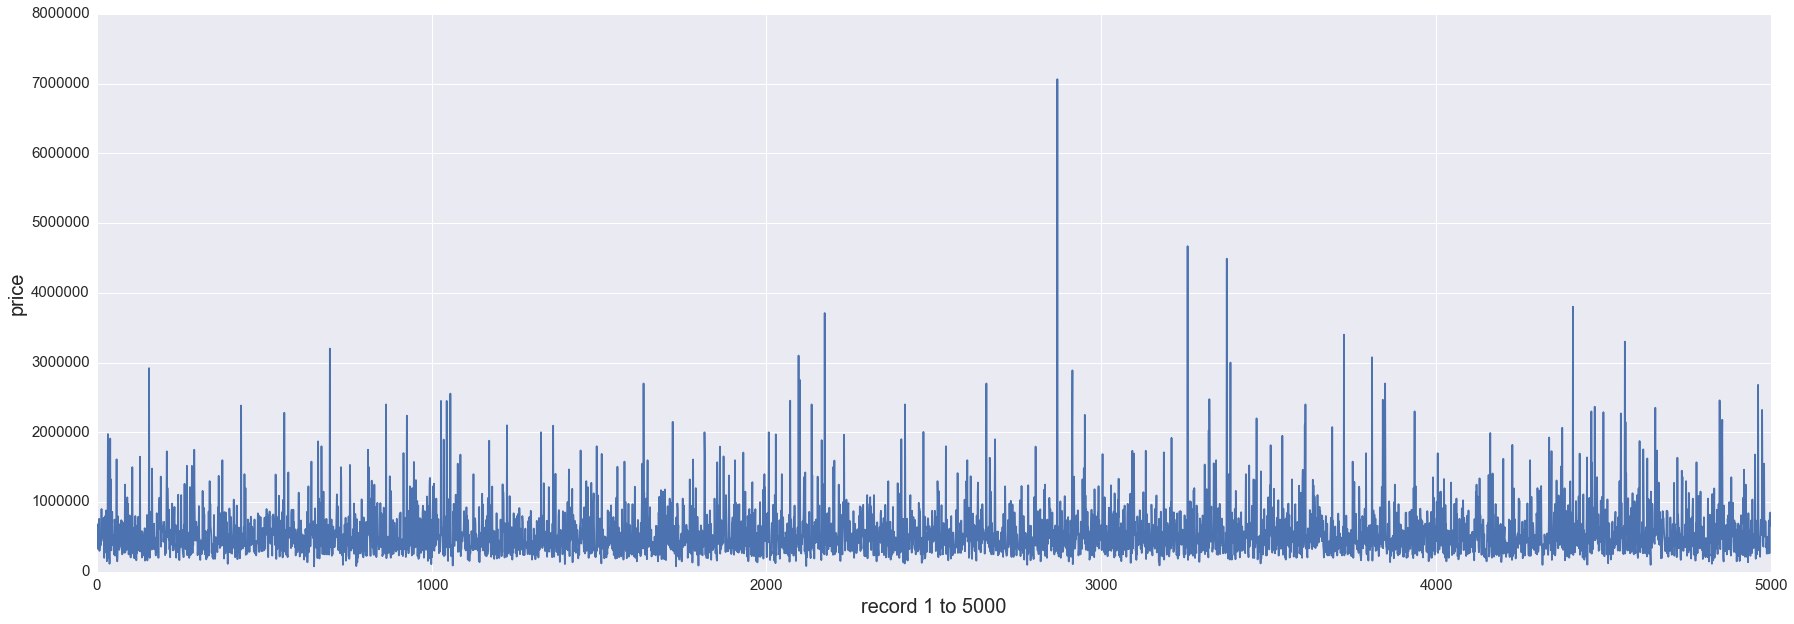

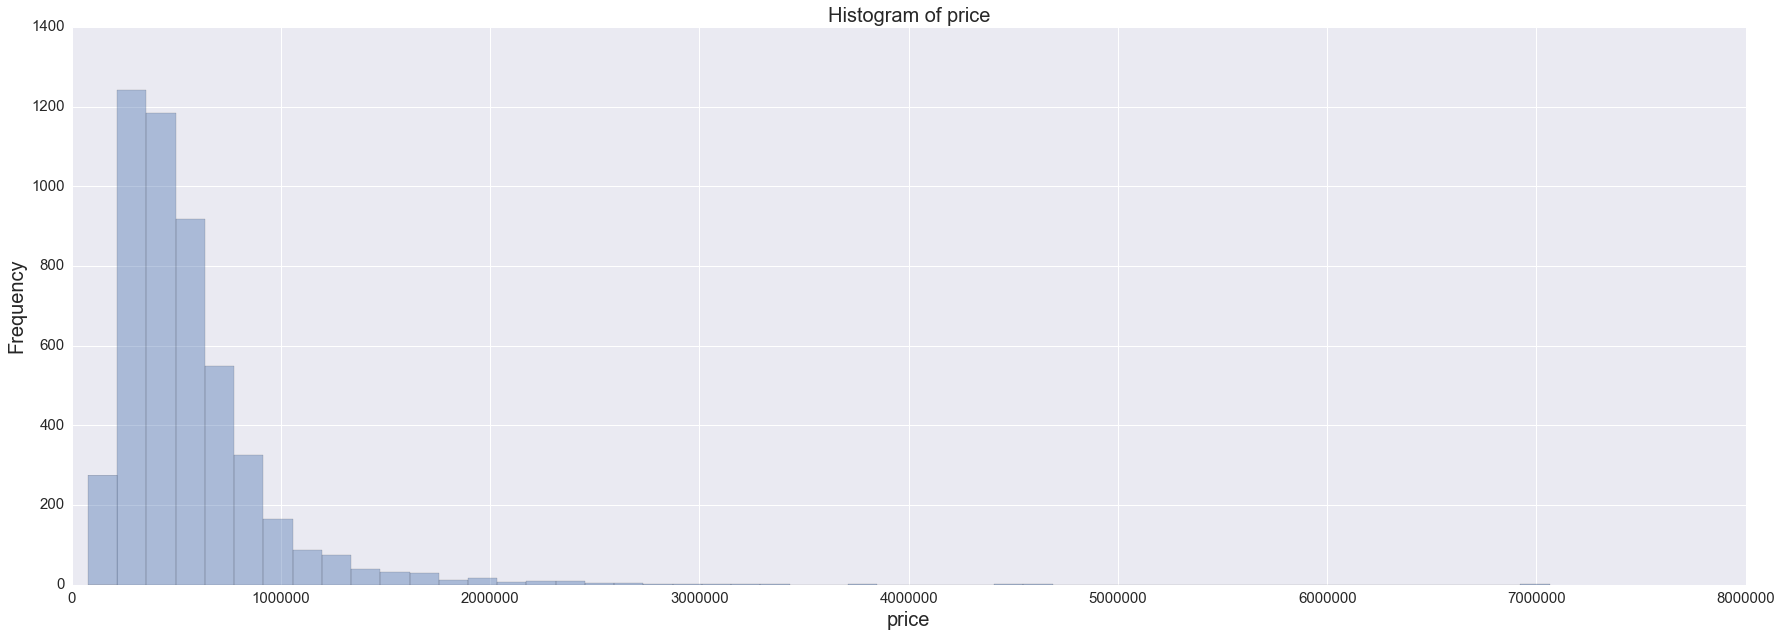

In [50]:
sns.set_style("darkgrid")
sns.set(font_scale = 1.5)

plt.figure(figsize = (30, 10))
plt.plot(df['price'])
plt.xlabel('record 1 to 5000',size=20)
plt.ylabel('price',size=20)

plt.figure(figsize = (30, 10))
plt.xlabel('price',size=20)
plt.ylabel('Frequency',size=20)
plt.title('Histogram of price',size=20)
sns.distplot(df['price'], kde=False)
plt.show()

#### Note:
* Notice that the data is heavily skewed to the right.

### 1. Apply z-score normalization to 'price':

In [51]:
#Z-Score Normalization 
std_scale = preprocessing.StandardScaler().fit(df[['price']])
df_std = std_scale.transform(df[['price']]) 
df['price_ZScore'] = df_std[:,0] 
df.head(3)

,bathrooms,bedrooms,city,country,floors,price,soldDate,sqft_above,sqft_basement,sqft_living,sqft_lot,statezip,street,view,waterfront,yr_built,yr_renovated,condition,price_ZScore
0,1.75,3,Kirkland,USA,1.0,630000,20140709T000000,1710,0,1710,8767,WA 98033,10515 115th Pl NE,0,0,1986,NaN,4.0,0.193390
1,3.25,3,Seattle,USA,3.0,599950,20140709T000000,1830,0,1830,1804,WA 98117,1501 NW 90th St,0,0,2014,NaN,3.0,0.113267
2,2.00,3,Seattle,USA,1.0,680000,20140709T000000,980,800,1780,5720,WA 98103,537 N 70th St,0,0,1925,NaN,5.0,0.326706


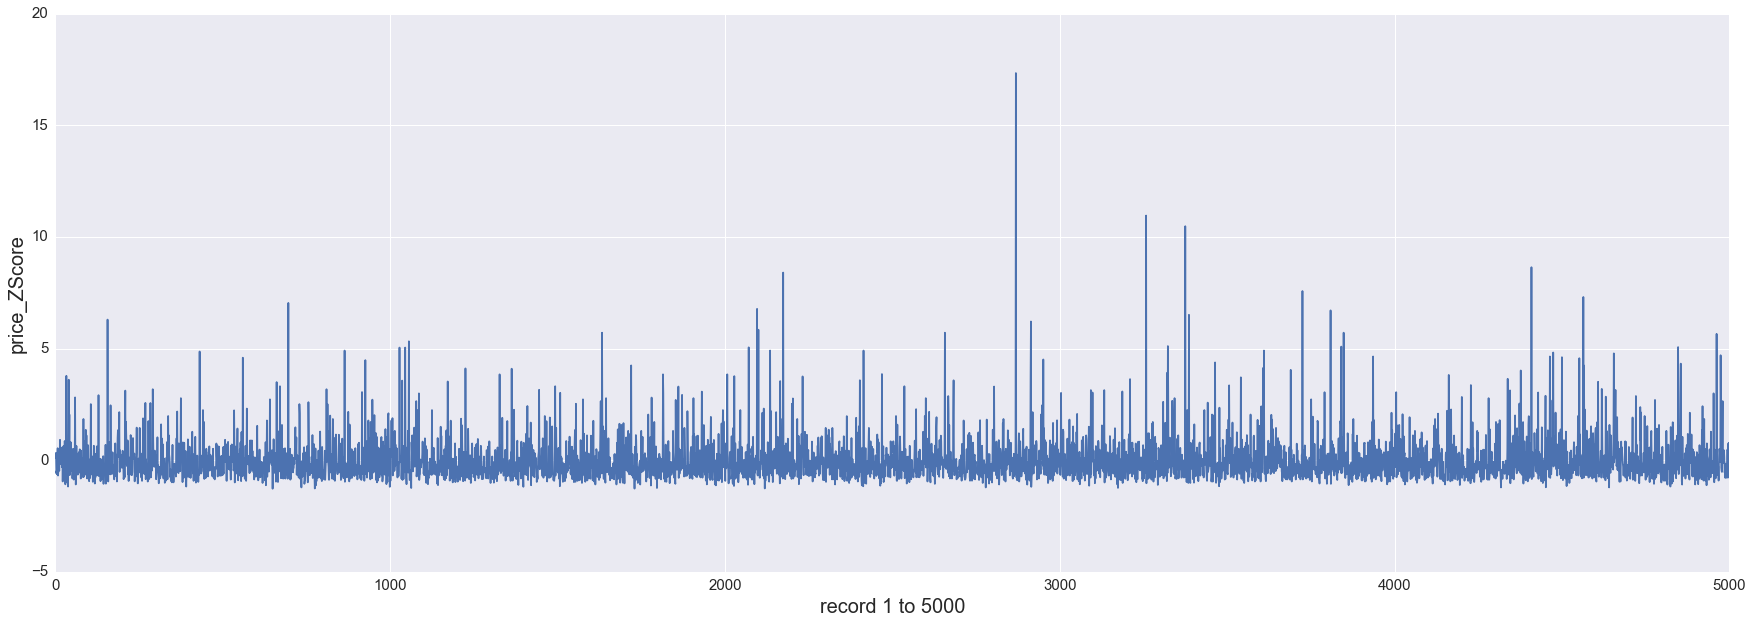

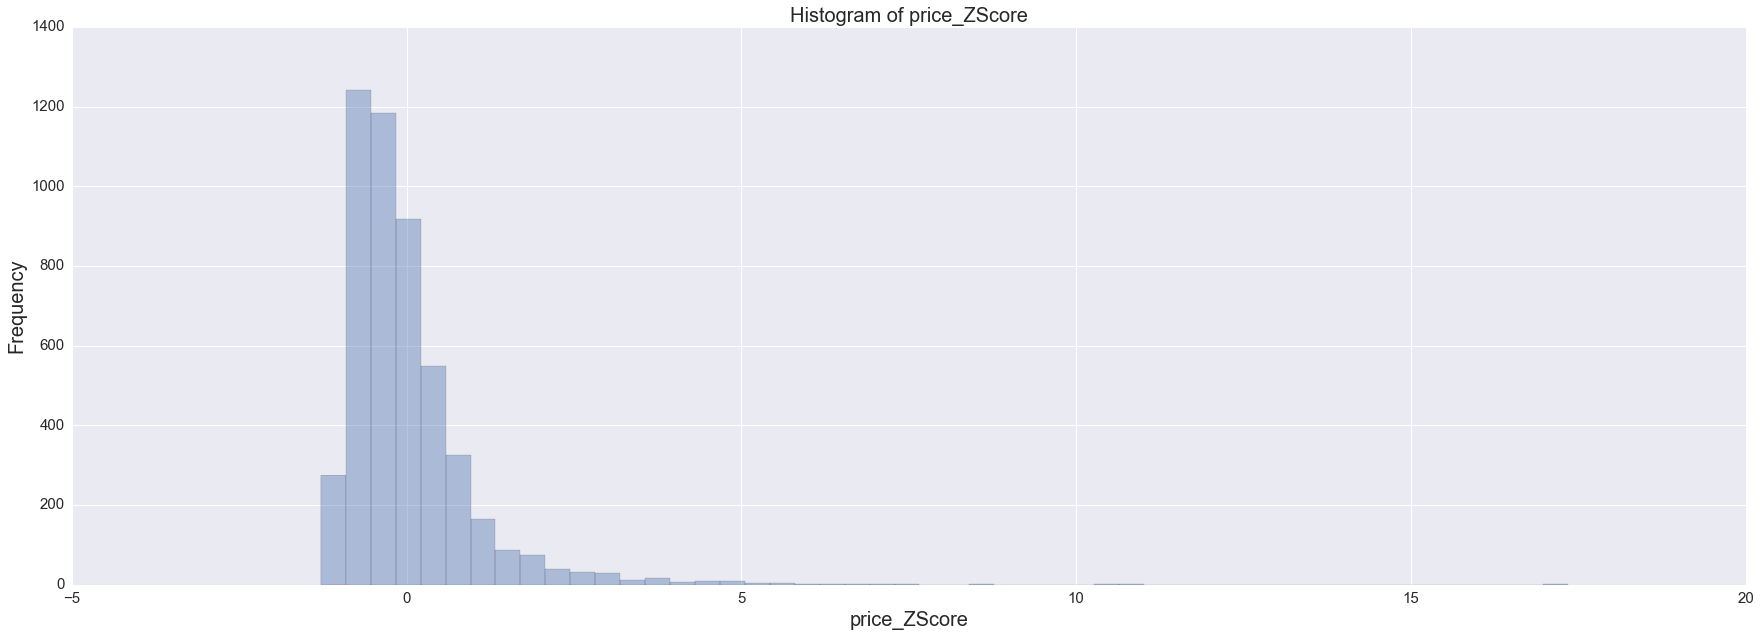

Mean after Z-score normalization:
 = 0.00
Standard deviation Z-score normalization:
 = 1.00


In [52]:
#visualize for normalization result
plt.figure(figsize = (30, 10))
plt.plot(df['price_ZScore'])
plt.xlabel('record 1 to 5000',size=20)
plt.ylabel('price_ZScore',size=20)

#histogram of price_ZScore
plt.figure(figsize = (30, 10))
plt.xlabel('price_log',size=20)
plt.ylabel('Frequency',size=20)
plt.title('Histogram of price_ZScore',size=20)
sns.distplot(df['price_ZScore'], kde=False)
plt.show()

print('Mean after Z-score normalization:\n = {:.2f}'
      .format(df['price_ZScore'].mean()))
print('Standard deviation Z-score normalization:\n = {:.2f}'
      .format(df['price_ZScore'].std()))

#### Note:
* Z-score normalization transforms data values having a mean of zero and a standard deviation of 1. 
* The data transformation doesn't change the variance of data. The above Histogram of price_Zscore shows the data, after transformation, still heavily skewed to the right.

### 2. Apply Min-Max normalization to 'price':

In [53]:
#MinMax Normalization
minmax_scale = preprocessing.MinMaxScaler().fit(df[['price']])
df_minmax = minmax_scale.transform(df[['price']])
df['price_MinMax'] = df_minmax[:,0] # so 'price_scaled' is price scaled
df.head(3)

,bathrooms,bedrooms,city,country,floors,price,soldDate,sqft_above,sqft_basement,sqft_living,sqft_lot,statezip,street,view,waterfront,yr_built,yr_renovated,condition,price_ZScore,price_MinMax
0,1.75,3,Kirkland,USA,1.0,630000,20140709T000000,1710,0,1710,8767,WA 98033,10515 115th Pl NE,0,0,1986,NaN,4.0,0.193390,0.079032
1,3.25,3,Seattle,USA,3.0,599950,20140709T000000,1830,0,1830,1804,WA 98117,1501 NW 90th St,0,0,2014,NaN,3.0,0.113267,0.074730
2,2.00,3,Seattle,USA,1.0,680000,20140709T000000,980,800,1780,5720,WA 98103,537 N 70th St,0,0,1925,NaN,5.0,0.326706,0.086191


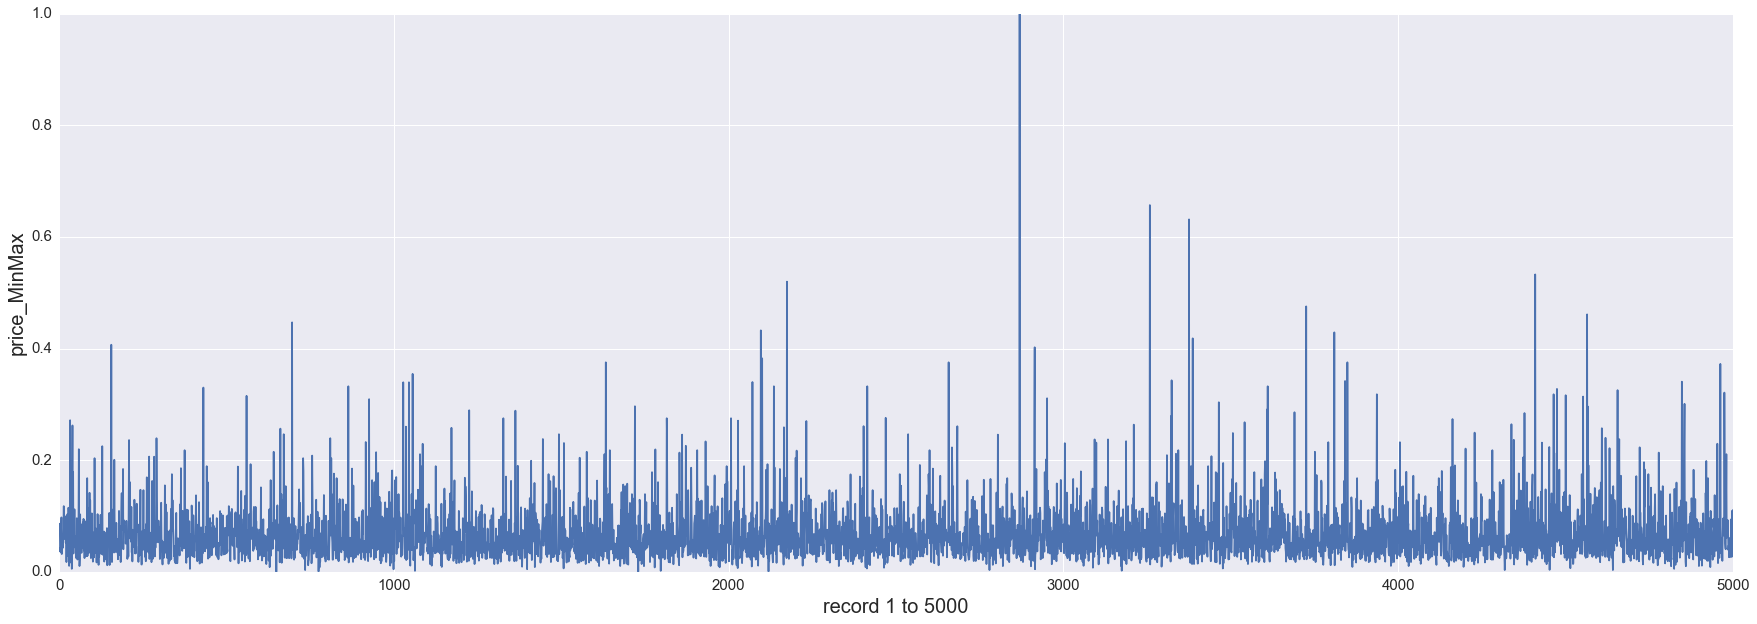

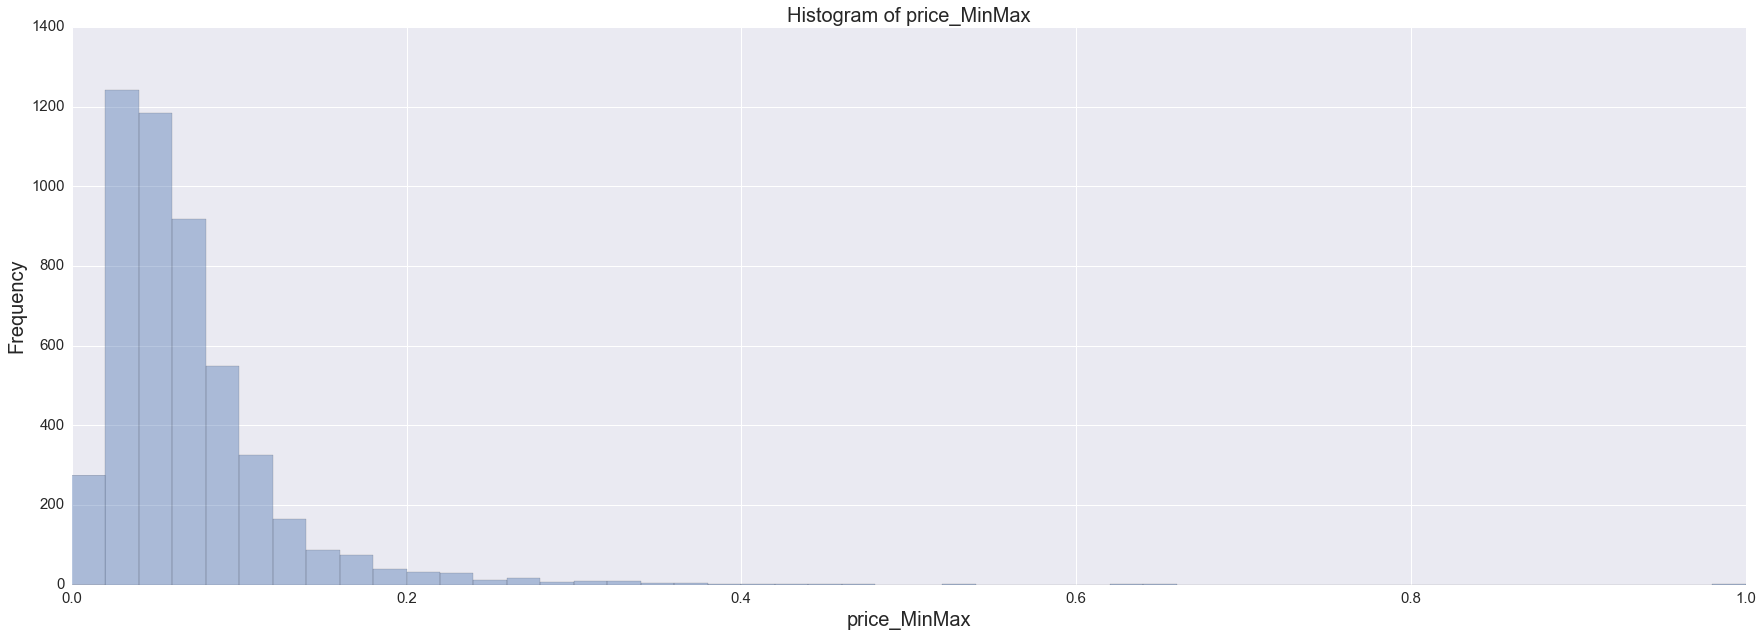

Maximum value of price after Min-Max normalization:
 = 1.00
Minimum value of price after Min-Max normalization:
 = 0.00


In [54]:
#visualize for normalization result
plt.figure(figsize = (30, 10))
plt.plot(df['price_MinMax'])
plt.xlabel('record 1 to 5000',size=20)
plt.ylabel('price_MinMax',size=20)

#histogram of price_MinMax
plt.figure(figsize = (30, 10))
plt.xlabel('price_log',size=20)
plt.ylabel('Frequency',size=20)
plt.title('Histogram of price_MinMax',size=20)
sns.distplot(df['price_MinMax'], kde=False)
plt.show()

print('Maximum value of price after Min-Max normalization:\n = {:.2f}'
      .format(df['price_MinMax'].max()))
print('Minimum value of price after Min-Max normalization:\n = {:.2f}'
      .format(df['price_MinMax'].min()))

### Note:
* Min Max normalization transforms data values that scale the data between 0 and 1.
* The data transformation doesn't change the variance of data. The above Histogram of price_MinMax shows the data, after transformation, still heavily skewed to the right.

### 3. Apply log transformation to 'price':

In [55]:
#Log transformation 
df['price_log'] = None
i = 0
for row in df.iterrows():
    df['price_log'].at[i] = math.log(df['price'][i])
    i += 1
df.head(3)

,bathrooms,bedrooms,city,country,floors,price,soldDate,sqft_above,sqft_basement,sqft_living,...,statezip,street,view,waterfront,yr_built,yr_renovated,condition,price_ZScore,price_MinMax,price_log
0,1.75,3,Kirkland,USA,1.0,630000,20140709T000000,1710,0,1710,...,WA 98033,10515 115th Pl NE,0,0,1986,NaN,4.0,0.193390,0.079032,13.3535
1,3.25,3,Seattle,USA,3.0,599950,20140709T000000,1830,0,1830,...,WA 98117,1501 NW 90th St,0,0,2014,NaN,3.0,0.113267,0.074730,13.3046
2,2.00,3,Seattle,USA,1.0,680000,20140709T000000,980,800,1780,...,WA 98103,537 N 70th St,0,0,1925,NaN,5.0,0.326706,0.086191,13.4298


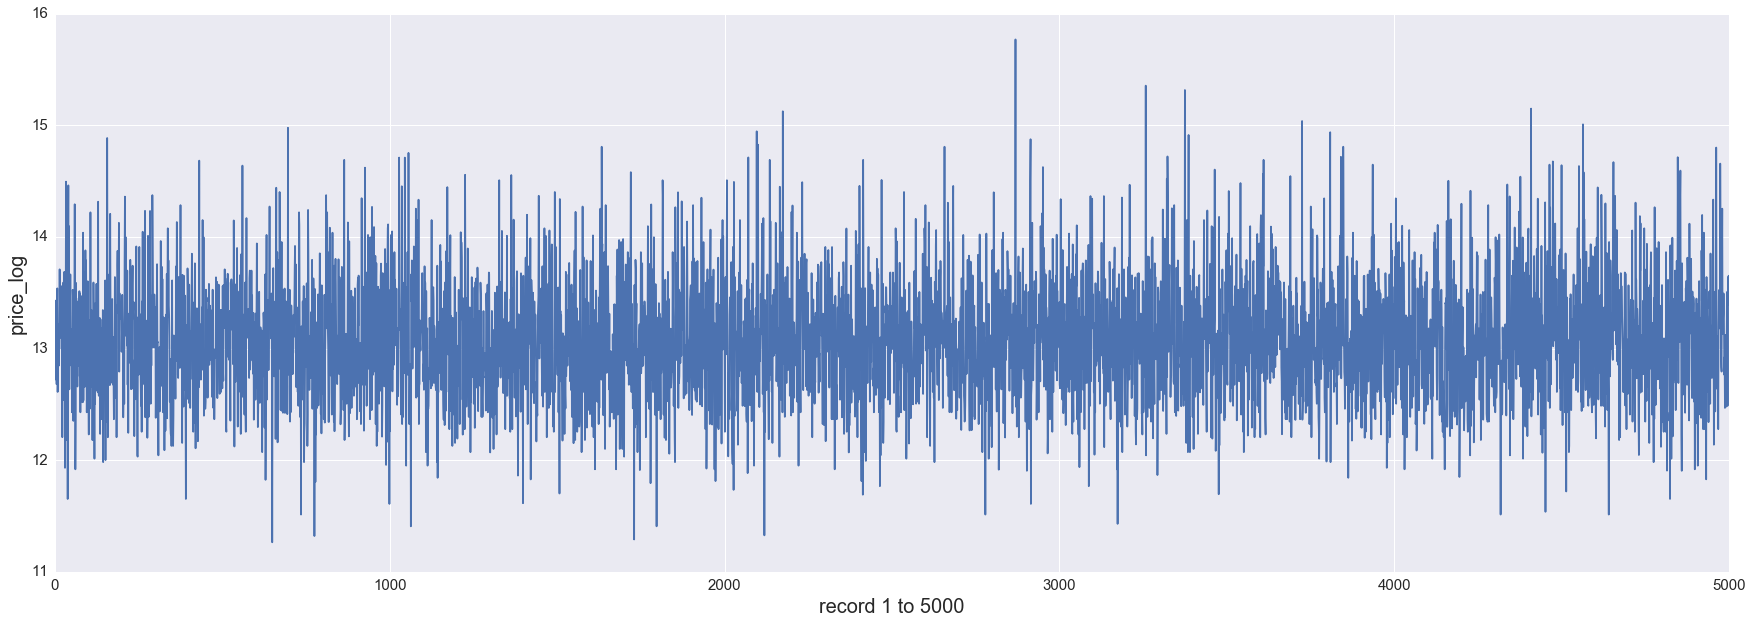

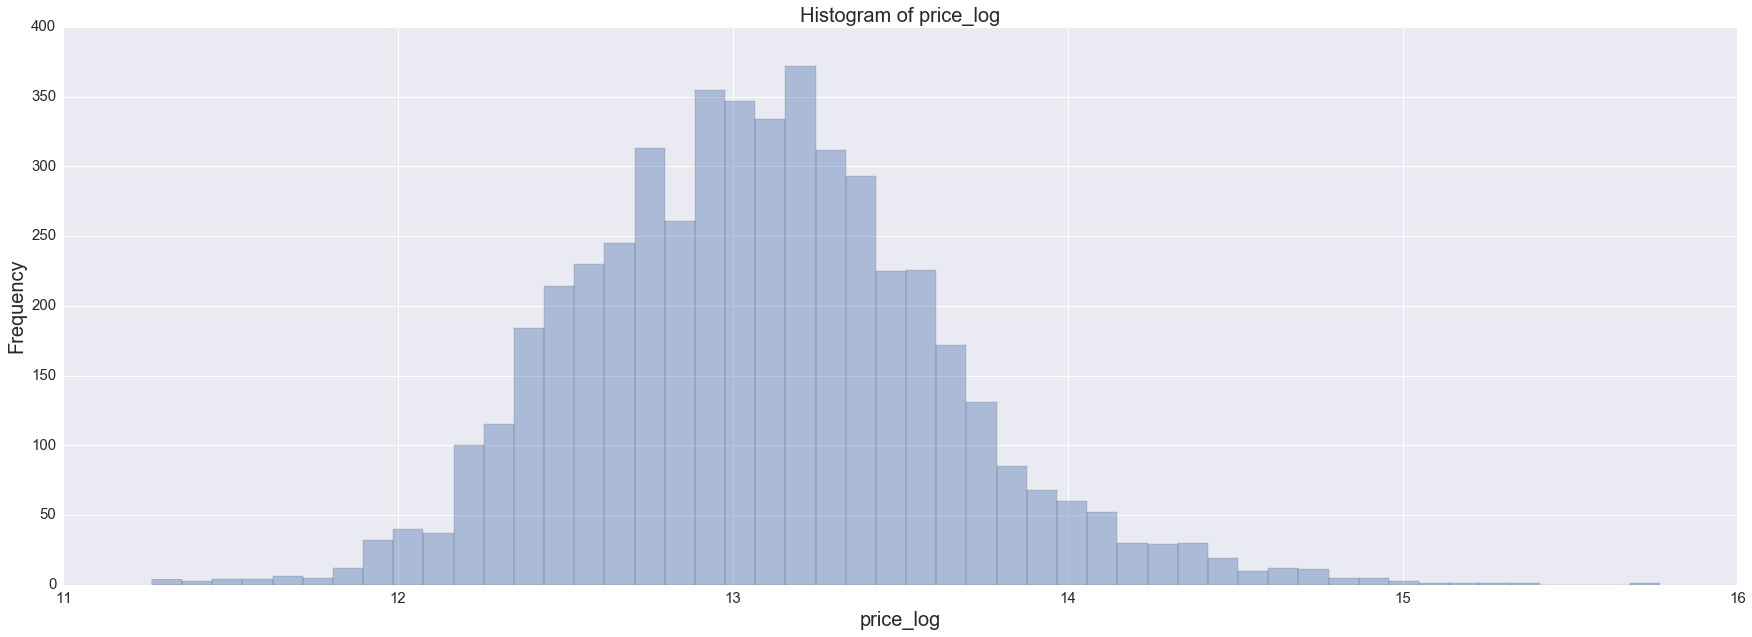

In [56]:
#visualize for data transformation result
plt.figure(figsize = (30, 10))
plt.plot(df['price_log'])
plt.xlabel('record 1 to 5000',size=20)
plt.ylabel('price_log',size=20)

#histogram of price_log
plt.figure(figsize = (30, 10))
plt.xlabel('price_log',size=20)
plt.ylabel('Frequency',size=20)
plt.title('Histogram of price_log',size=20)
sns.distplot(df['price_log'], kde=False)
plt.show()

#### Note:
* Log transformation normalizes the variable of price. The above Histogram of price_log shows the data, after transformation, is close to a standard normal distribution that without skewed to right or left.


### Summary of data normalization/ transformation for 'price': 
* Log transformation for 'price' is better when we are using the dataset to make a linear regression model for the house price predictions.

(We have applied three methods of data normalization/transformation for the 'price' data.        
 And all the three methods have changed the scaling of the price 'data' to became smaller that close to the scale of other numerical type of data in the dataset. However, only Log transformation helps to normalize the data from a right skewed distribution to a standard normal distribution.                 
 If we are using the dataset to build regression model for the price prediction, using log transformation to normalize the heavily right skewed variable would allow linear regression algorithm to make better predictions as the algorithm of the regression model rely on the assumption of linear relationships.)

### 4. Output integrated dataset:

In [60]:
#rearrange dataframe columns sequence
cols = df.columns.tolist()
cols = cols[6:7]+ cols[12:13] + cols[2:3] + cols[11:12] + cols[3:4] + cols[0:2] + cols[4:5] + \
        cols[7:11] + cols[13:15] + cols[17:18] + cols[15:17] + cols[5:6] + cols[-3:]
df_fn = df[cols]
df_fn.head(3)

,soldDate,street,city,statezip,country,bathrooms,bedrooms,floors,sqft_above,sqft_basement,...,sqft_lot,view,waterfront,condition,yr_built,yr_renovated,price,price_ZScore,price_MinMax,price_log
0,20140709T000000,10515 115th Pl NE,Kirkland,WA 98033,USA,1.75,3,1.0,1710,0,...,8767,0,0,4.0,1986,NaN,630000,0.193390,0.079032,13.3535
1,20140709T000000,1501 NW 90th St,Seattle,WA 98117,USA,3.25,3,3.0,1830,0,...,1804,0,0,3.0,2014,NaN,599950,0.113267,0.074730,13.3046
2,20140709T000000,537 N 70th St,Seattle,WA 98103,USA,2.00,3,1.0,980,800,...,5720,0,0,5.0,1925,NaN,680000,0.326706,0.086191,13.4298


In [61]:
#correlation with 'price':
df_fn.corr()[['price']].sort_values(by='price', ascending=False)

,price
price_ZScore,1.000000
price_MinMax,1.000000
price,1.000000
sqft_living,0.718001
sqft_above,0.618625
bathrooms,0.542543
view,0.399023
sqft_basement,0.343546
bedrooms,0.338079
floors,0.263909


#### Note:
* The intergrated dataset contains attributes including:         
'soldDate', 'street', 'city', 'statezip', 'country', 'bathrooms','bedrooms','floors','sqft_above', 
'sqft_basement', 'sqft_living', 'sqft_lot', 'view', 'waterfront', 'condition','yr_built', 'yr_renovated',
'price','price_ZScore','price_MinMax','price_log'         
(total 18 attributes together with 3 variables from the data normalization/ transformation of 'price'.)
* Noticed that 'sqft_living' as a derived attribute of 'sqft_basement' + 'sqft_living'. I remained this attribute in the final intergrated dataset is because that attribute 'sqft_living', compared to 'sqft_basement' and 'sqft_living', has a higher correlation to the 'price' (correlation coefficient = 0.718) that it is a good variable with high correlation to 'price' which could be a good feature for the price prediction model.

#### Write intergrated dataset to a new csv file

In [62]:
output_file = open ("HSU_28397371_ass3_data.csv", "w+")  
df_fn.to_csv(output_file,index= False)
output_file.close()

## End.